<a href="https://colab.research.google.com/github/ThiagSampaio/DeepLearning/blob/main/Regress%C3%A3o_Log%C3%ADstica_com_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Logística com Rede Neural

Vamos construir um classificador de regressão logística para reconhecer gatos.

** O que será mostrado: **
- Construir uma arquitetura geral de um algoritmo de aprendizado, incluindo:
    - Inicializando os parâmetros
    - Calculando a função custo e seu gradiente
    - Usando um algoritmo de otimização(gradiente descente)
- Pegar as três funções acima e aplicá-las em uma função modelo principal, na ordem correta.

## Tabela de Conteúdos
- [1 - Pacotes](#1)
- [2 - Olhando o problema](#2)
    - [Demonstração 1](#ex-1)
    - [Demonstração 2](#ex-2)
- [3 - Arquitetura geral de um algoritmo de aprendizado](#3)
- [4 - Construindo as partes do nosso algoritmo](#4)
    - [4.1 - Funções úteis](#4-1)
        - [Demonstração 3 - sigmoid](#ex-3)
    - [4.2 - Inicializando parâmetros](#4-2)
        - [Demonstração 4 - inicializando_com_zeros](#ex-4)
    - [4.3 - Propagação direta e reversa](#4-3)
        - [Demonstração 5 - propagação](#ex-5)
    - [4.4 - Optimization](#4-4)
        - [Demonstração 6 - otimização](#ex-6)
        - [Demonstração 7 - predição](#ex-7)
- [5 - Aglutinar todas as funções em um modelo](#5)
    - [Demonstração 8 - modelo](#ex-8)
- [6 - Análises](#6)
- [7 - Testando com sua prória imagem](#7)



<a name='1'></a>
## 1 - Pacotes ##

Primeiro, vamos rodar a célula abaixo para importar todos os pacotes que usaremos durante essa demonstração.
- [numpy](https://numpy.org/doc/1.20/) é um pacote fundamental para computação científica com python
- [h5py](http://www.h5py.org) é um pacote comum para interagir com arquivos armazenados como .h5
- [matplotlib](http://matplotlib.org) é uma famosa biblioteca para plotar gráficos.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) são usados para testar o modelo com sua própria figura no final do estudo. 

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils  import load_dataset
from public_tests import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Olhando para o problema##

**Declaração do Problema**: Foi dado a você um dataset("data.h5") contendo:

    - um conjunto de treinamento de imagens m_train rotuladas como gato (y = 1) ou não gato (y = 0)
    - um conjunto de teste de imagens m_test rotuladas como gato ou não gato
    - cada imagem tem forma (num_px, num_px, 3) onde 3 é para os 3 canais (RGB). Assim, cada imagem é quadrada (altura = num_px) e (largura = num_px).

Construiremos um algoritmo de reconhecimento de imagem simples que pode classificar corretamente as imagens como gatos ou não.

Vamos nos familiarizar mais com o conjunto de dados. Carregue os dados executando o código a seguir.

In [3]:
# Carregando os dados(gatos/não-gatos)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Adicionamos "_orig" no final dos dados de imagem (treino e teste) porque iremos fazer uma pré-processamento. Depois de processarm nós vamos acabar tendo train_set_x e test_set_x

Cada linha do nosso train_set_x_orig and test_set_x_orig é uma array representando a imagem. Podemos visualizar um exemplo rodando o código abaixo.

y = [1], é um 'cat' na foto.


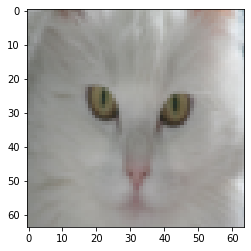

In [4]:
#Exemplo de imagem
index = 50
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", é um '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' na foto.")

Muitos bugs em aprendizagem profunda vem de ter matrizes/vetores com dimensões que não combinam. Se você puder manter suas matrizes/vetores com dimensões corretas, teremos um longo caminho sem bugs.

<a name='ex-1'></a>
### Demonstração 1
Vamos achar os valores para:

    - m_train (número de exemplos para o treino)
    - m_test (número de exemplos para o teste)
    - num_px (= altura = largura das imagens de treino)

Lembre-se que `train_set_x_orig` é uma array numpy com o shape (m_train, num_px, num_px, 3).


In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Numero de exemplos para o treinamento: m_train = " + str(m_train))
print ("Numero de exemplos para o teste: m_test = " + str(m_test))
print ("Altura/Largura de cada image: num_px = " + str(num_px))
print ("Cada imagem com o tamanho: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Numero de exemplos para o treinamento: m_train = 209
Numero de exemplos para o teste: m_test = 50
Altura/Largura de cada image: num_px = 64
Cada imagem com o tamanho: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Remodelaremos os conjuntos de dados de treinamento e teste para que as imagens de tamanho (num_px, num_px, 3) sejam achatadas em vetores únicos de forma (num_px ∗ num_px ∗ 3, 1).

In [6]:
#Remodelando os dados de treino e teste

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


Para representar imagens coloridas(RGB), deve ser especificado para cada pixel os valores de cada canal, então cada pixel é na verdade um vetor de três números indo de 0 à 255.

Um passo de pré-processamento em machine learning é centrar e padronizar nosso conjunto de dados, significando que você subtraí a média de toda array numpy de cada exemplo e depois divide cada exemplo pelo desvio da média padrão de toda numpy array. Porém para um dataset de imagem, é mais simples e mais conveniente e quase sempre entrega um bom resultado simplesmente dividir cada linha do dataset por 255.


In [7]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
    
    
**O que precisa ser lembrado:**

Passos comuns para pré-processamento de um novo conjunto de dados:
- Descobrir as dimensões e formas do problema (m_train, m_test, num_px, ...)
- Remodele os conjuntos de dados de forma que cada exemplo seja agora um vetor de tamanho (num_px \ * num_px \ * 3, 1)
- "Padronizar" os dados

<a name='3'></a>
## 3 - Arquitetura geral de um algoritmo de aprendizado ##

É hora de projetar um algoritmo simples para distinguir imagens de gatos de imagens que não sejam de gatos.

Você vai construir uma regressão logística, usando uma mentalidade de rede neural. A figura a seguir explica por que ** Regressão logística é na verdade uma rede neural muito simples! **

![](https://drive.google.com/uc?export=view&id=1I_VwzE_JP4-lVfabHhyoh1DDUmjsfn9G)

** Expressão matemática do algoritmo **:


Por um exemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

O custo é então calculado somando todos os exemplos de treinamento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

** Principais etapas **:
Neste exercício, você executará as seguintes etapas:

    - Inicialize os parâmetros do modelo
    - Aprenda os parâmetros do modelo, minimizando o custo
    - Use os parâmetros aprendidos para fazer previsões (no conjunto de teste)
    - Analisar os resultados e concluir

<a name='4'></a>
## 4 - Construindo as partes do nosso algoritmo ## 

Os principais passos para construir uma Rede Neural são:
1. Definir a estrutura do modelo (tanto o número de variáveis de entrada
2. Inicializar os parâmetros do modelo
3. Loop:
    - Calcular a perda recorrente (propagação direta)
    - Calcular o gradiente (propagação inversa)
    - Atualizar os parametros (gradiente descente)

Normalmente iremos construir 1-3 separadamente e integrar tudo em umna função que chamaremos `model()`.

<a name='4-1'></a>
### 4.1 - Funções úteis 

<a name='ex-3'></a>
### Demonstração 3 - sigmoid
Vamos implementar uma função chamada `sigmoid()`. Como mostrado na figura acima, precisamos computar $sigmoid(z) = \frac{1}{1 + e^{-z}}$ para $z = w^T x + b$ para fazer previsões.

In [8]:
# Função de classificação: sigmoid

def sigmoid(z):
  """
  Calcular o sigmoid de z

  Argumentos:
  z -- Um número ou uma numpy array de qualquer tamanho

  Retorna:
  s -- sigmoid(z)
  """
  s = 1/(1 + np.exp(-z))

  return s

In [9]:
# Teste_1 da função criada

print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid_test(sigmoid)

sigmoid([0, 2]) = [0.5        0.88079708]
All tests passed!


In [10]:
# Teste_2 da função criada

x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


<a name='4-2'></a>
### 4.2 - Inicializando parâmetros

<a name='ex-4'></a>
### Demonstração 4 - inicializando com zeros 
Vamos implementar uma função de inicialização dos parâmetros W e b, fazendo com que eles se inicializem com valores = 0

In [11]:
def initialize_with_zeros(dim):
  """
  Esta função cria um vetor de zeros com o shape (dim,1) para W e inicializa b com 0

  Argumento:
  dim -- tamanho do vetor w que queremos(ou número de parametros neste caso)

  Retorna:
  w -- inicializado como um vetor de tamando (dim,1)
  b -- Escalar inicial (correspondente ao viés) do tipo float
  """
  w = np.zeros((dim,1))
  b = 0.0

  return w, b

In [12]:
# Teste

dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

initialize_with_zeros_test(initialize_with_zeros)

w = [[0.]
 [0.]]
b = 0.0
All tests passed!


<a name='4-3'></a>
### 4.3 - Propagação direta e reversa

Agora que nossos parâmetros estão inicializados, podemos fazer os passos da propagação direta e reversa para os parâmentros de aprendizado

<a name='ex-5'></a>
### Demonstação 5 - Propagação
Vamos implementar a função `propagate()` que computa a função custo e o seu gradiente.

**Fórmulas**:

Propagação Direta:
- Pegamos X
- Computamos $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculamos o custo: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Propagação Inversa:

As fórmulas que iremos utilizar:


$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$


$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$



In [38]:
def propagate(w, b, X, Y):
      """
      Implementação da função custo e seu gradiente para a propagção explicada acima.

      Argumentos:
      w -- pesos, uma array numpy de tamanho (num_px * num_px * 3, 1)
      b -- viés, um escalar. 
      X -- dados de tamanho (num_px * num_px * 3, numero de exemplos)
      Y -- Vetor de respostas (contendo 0 se não for gato e 1 se for) de tamanho (1, numero de exemplos)

      retorna:
      """
      m = X.shape[1]

      # Propagação direta (De X para o Custo)

      A = sigmoid(np.dot(w.T,X) + b)
      cost = (-1/m)*(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))

      # Propagação Reversa (Achar o gradiente)

      dw = 1 / m *(np.dot(X, (A-Y).T))
      db = 1 / m *(np.sum(A - Y))

      assert(dw.shape == w.shape)
      assert(db.dtype == float)
    
      cost = np.squeeze(np.array(cost))
      assert(cost.shape == ())
    
      grads = {"dw": dw,
              "db": db}
    
      return grads, cost


In [39]:
# Teste da função 
w =  np.array([[1.], [2.]])
b = 2.
X =np.array([[1., 2., -1.], [3., 4., -3.2]])
Y = np.array([[1, 0, 1]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

propagate_test(propagate)

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553
All tests passed!


<a name='4-4'></a>
### 4.4 - Otimização
-  Inicializamos os parâmetros.
-  Computamos a função custo e seu gradiente 
-  Precisamos fazer o update dos parâmetros usando gradiente descente

### Demonstração 6 - Otimização
Vamos escrever a função de otimização. O objetivo é aprender $w$ e $b$ para minimizar a função custo $J$. Para o parâmetro $\theta$, a fórmula de atualização é $ \theta = \theta - \alpha \text{ } d\theta$, onde $\alpha$ é a taxa de aprendizagem

In [51]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
  """
  Esta função otimiza w e b rodando o algoritmo gradiente descendente

  Argumentos:
  w -- pesos, uma array numpy de tamanho(num_px*num_px*3, 1)
  b -- viés,um escalar
  X -- Dados de formato (num_px * num_px * 3, 1)
  Y -- Vetor de respostas de formato(1, numero de exemplos)
  num_iterations -- numero de iterações do loop de otimização
  learning_rate -- taxa de aprendizado do gradiente descendente
  print_cost -- Verdadeiro para printar a perda a cada 100 passos

  Retorna:
  params -- Dicionario contendo os pesos w e os vieses b
  grads -- Dicionario contendo os gradientes dos pesos e vieses com sua respectiva função custo
  costs -- lista de todos os custos computados durante a otimização, será usado para plotar o gráfico de aprendizado
  """
  w = copy.deepcopy(w)
  b = copy.deepcopy(b)

  costs = []

  for i in range(num_iterations):
    
    #  Calculo do custo e gradiente
    grads,cost = propagate(w, b, X, Y)

    # Pegando os valores de grads
    dw = grads["dw"]
    db = grads["db"]

    #Regra de update
    w = w - learning_rate*dw
    b = b - learning_rate*db

    #Guardando dados
    if i % 100 == 0:
      costs.append(cost)

      if print_cost:
        print("Custo depois da iteração %i: %f" %(i, cost))

  params = {"w":w,
            "b":b}

  grads = {"dw":dw,
            "db":db}
  return params, grads, costs


In [52]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

optimize_test(optimize)

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652
Costs = [array(5.80154532)]
All tests passed!


<a name='ex-7'></a>
### Exercise 7 - predição
A função anterior irá ter como o output w e b. 
Nós podemos usar w e b para predizer as respostar para o dataset X. Vamos implementar a função `predict()`. Para isso devemos seguir os seguintes passos:

1. Calcular $\hat{Y} = A = \sigma(w^T X + b)$

2. Converter as entradas em 0 (se a ativação <= 0.5) ou 1( se ativação > 0.5), guardar as predições em `Y_prediction`.




In [53]:
def predict(w, b, X):
  """
  Predizer quando a resposta for 0 ou 1 usando regressão logistica
  
  Argumentos:
  w -- pesos, uma array numpy de tamanho(num_px*num_px*3, 1)
  b -- viés, escalar.
  X -- Dados de formato (num_px * num_px * 3, 1)

  Retorna:

  Y_prediction -- uma array numpy (vetor) contendo todas predições (0/1) para os exemplos em X
  """
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0],1)

  #Computar o vetor A prevendo a probabilidade de ser um gato na figura
  A = sigmoid(np.dot(w.T,X) + b)

  for i in range(A.shape[1]):
        
    if (A[0][i] <= 0.5):
      Y_prediction[0][i] = 0
    else:
      Y_prediction[0][i] = 1
      
  return Y_prediction       

In [54]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predict_test(predict)

predictions = [[1. 1. 0.]]
All tests passed!


In [58]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=10000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # (≈ 1 line of code)   
    # initialize parameters with zeros 
    # w, b = w, b = initialize_with_zeros(X_train.shape[0])
    
    #(≈ 1 line of code)
    # Gradient descent 
    # params, grads, costs = ...
    
    # Retrieve parameters w and b from dictionary "params"
    # w = ...
    # b = ...
    
    # Predict test/train set examples (≈ 2 lines of code)
    # Y_prediction_test = ...
    # Y_prediction_train = ...
    
    # YOUR CODE STARTS HERE
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs =  optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # YOUR CODE ENDS HERE

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [59]:
model_test(model)

All tests passed!


In [62]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=50000, learning_rate=0.005, print_cost=True)

Custo depois da iteração 0: 0.693147
Custo depois da iteração 100: 0.584508
Custo depois da iteração 200: 0.466949
Custo depois da iteração 300: 0.376007
Custo depois da iteração 400: 0.331463
Custo depois da iteração 500: 0.303273
Custo depois da iteração 600: 0.279880
Custo depois da iteração 700: 0.260042
Custo depois da iteração 800: 0.242941
Custo depois da iteração 900: 0.228004
Custo depois da iteração 1000: 0.214820
Custo depois da iteração 1100: 0.203078
Custo depois da iteração 1200: 0.192544
Custo depois da iteração 1300: 0.183033
Custo depois da iteração 1400: 0.174399
Custo depois da iteração 1500: 0.166521
Custo depois da iteração 1600: 0.159305
Custo depois da iteração 1700: 0.152667
Custo depois da iteração 1800: 0.146542
Custo depois da iteração 1900: 0.140872
Custo depois da iteração 2000: 0.135608
Custo depois da iteração 2100: 0.130708
Custo depois da iteração 2200: 0.126137
Custo depois da iteração 2300: 0.121861
Custo depois da iteração 2400: 0.117855
Custo depois